# Data Cleaning and Feature Engineering

This notebook focuses on:
1. Cleaning the dataset based on EDA findings
2. Engineering three new features to improve readmission prediction

## Overview
Based on the EDA:
- High missing data in weight (97%), baseline_anxiety_score (95%), followup_anxiety_score (83%)
- Placeholder values ('?') in medical_specialty (49%), payer_code (40%)
- Visit history is a strong predictor (0 visits: 36.1% readmission vs 1+ visits: 58.1%)
- Clinical complexity indicators (diagnoses, medications, length of stay) differ between readmitted and non-readmitted patients


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Load the data
df = pd.read_csv('Data/anxiety_disorder_admission_data.csv')

print(f"Initial dataset shape: {df.shape}")
print(f"Initial memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


Initial dataset shape: (86385, 50)
Initial memory usage: 163.72 MB


## Data Cleaning, 

### Handle Missing Data and Placeholder Values


In [2]:
# Make a copy for cleaning
df_clean = df.copy()

# Convert '?' and 'None' to NaN for consistency
print("Converting placeholder values to NaN...")
for col in df_clean.columns:
    if df_clean[col].dtype == 'object':
        df_clean[col] = df_clean[col].replace(['?', 'None'], np.nan)

# Check missing data after conversion
missing_data = []
for col in df_clean.columns:
    missing_count = df_clean[col].isnull().sum()
    if missing_count > 0:
        missing_data.append({
            'Column': col,
            'Missing_Count': missing_count,
            'Missing_Percent': (missing_count / len(df_clean)) * 100
        })

missing_df = pd.DataFrame(missing_data).sort_values('Missing_Percent', ascending=False)
print()
print("Columns with missing data (after converting '?' and 'None'):")
print(missing_df.head(10))


Converting placeholder values to NaN...

Columns with missing data (after converting '?' and 'None'):
                   Column  Missing_Count  Missing_Percent
1                  weight          83685        96.874457
7  baseline_anxiety_score          81843        94.742143
8  followup_anxiety_score          71987        83.332755
3       medical_specialty          42451        49.141633
2              payer_code          34232        39.627250
0                    race           1917         2.219135
6                  diag_3           1206         1.396076
5                  diag_2            297         0.343810
4                  diag_1             17         0.019679


In [3]:
# Drop columns with >90% missing data (not useful for modeling)
columns_to_drop = []
for col in df_clean.columns:
    missing_pct = (df_clean[col].isnull().sum() / len(df_clean)) * 100
    if missing_pct > 90:
        columns_to_drop.append(col)
        print(f"Dropping {col}: {missing_pct:.2f}% missing")

df_clean = df_clean.drop(columns=columns_to_drop)
print()
print(f"Dropped {len(columns_to_drop)} columns")
print(f"Dataset shape after dropping high-missing columns: {df_clean.shape}")


Dropping weight: 96.87% missing
Dropping baseline_anxiety_score: 94.74% missing

Dropped 2 columns
Dataset shape after dropping high-missing columns: (86385, 48)


In [4]:
# Handle remaining missing values
# For categorical columns with moderate missing (<50%), create 'Missing' category
# For numeric columns, keep NaN for now (can impute later if needed)

categorical_cols = df_clean.select_dtypes(include=['object']).columns
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns

print("Handling missing values in categorical columns...")
for col in categorical_cols:
    if col != 'readmitted':  # Don't modify target variable
        missing_pct = (df_clean[col].isnull().sum() / len(df_clean)) * 100
        if missing_pct > 0 and missing_pct < 50:
            df_clean[col] = df_clean[col].fillna('Missing')
            print(f"  {col}: {missing_pct:.2f}% missing -> filled with 'Missing'")

print()
print("Handling missing values in numeric columns...")
# For numeric columns, we'll keep NaN for now (can be handled during modeling)
# But let's at least check what we have
for col in numeric_cols:
    missing_pct = (df_clean[col].isnull().sum() / len(df_clean)) * 100
    if missing_pct > 0:
        print(f"  {col}: {missing_pct:.2f}% missing (keeping as NaN for now)")

print()
print(f"Final dataset shape: {df_clean.shape}")
print(f"Remaining missing values: {df_clean.isnull().sum().sum()}")


Handling missing values in categorical columns...
  race: 2.22% missing -> filled with 'Missing'
  payer_code: 39.63% missing -> filled with 'Missing'
  medical_specialty: 49.14% missing -> filled with 'Missing'
  diag_1: 0.02% missing -> filled with 'Missing'
  diag_2: 0.34% missing -> filled with 'Missing'
  diag_3: 1.40% missing -> filled with 'Missing'

Handling missing values in numeric columns...

Final dataset shape: (86385, 48)
Remaining missing values: 71987


### Handle followup_anxiety_score (83% missing)

Create a binary indicator for whether the score was measured


In [5]:
# Create indicator for followup_anxiety_score measurement
if 'followup_anxiety_score' in df_clean.columns:
    df_clean['followup_anxiety_score_measured'] = df_clean['followup_anxiety_score'].notna().astype(int)
    # Drop original column (too much missing data)
    df_clean = df_clean.drop(columns=['followup_anxiety_score'])
    print("Created 'followup_anxiety_score_measured' indicator")
    print(f"Follow-up score measured: {df_clean['followup_anxiety_score_measured'].sum():,} ({df_clean['followup_anxiety_score_measured'].mean()*100:.1f}%)")


Created 'followup_anxiety_score_measured' indicator
Follow-up score measured: 14,398 (16.7%)


## Feature Engineering

Creating **three new interpretable features** to help predict readmission:

Features need to help explain WHY someone is high-risk, not obscure the underlying drivers with composite scores.

1. **Multiple Emergency Visits**: Flags patients with 2+ emergency visits (indicates recurrent instability)
2. **High Comorbidity Count**: Flags patients with above-median number of diagnoses (indicates complex medical conditions)
3. **Medication Change Count**: How many times a patient has had their medication changed

These features are:
- **Interpretable**: Directly explain the risk factor
- **Actionable**: Can be used to identify specific patient groups for intervention
- **Transparent**: Don't hide the underlying drivers (number of ER visits, number of diagnoses)


### Feature 1: Multiple Emergency Visits

**Rationale**: 
- EDA showed visit history is a **very strong predictor**:
  - 0 visits: 36.1% readmission rate
  - 1+ visits: 58.1% readmission rate  
  - 3+ visits: 67.5% readmission rate
- Emergency visits indicate acute health crises
- Multiple emergency visits (2+) suggest **recurrent instability** or **ongoing health issues** that aren't being managed well
- This is interpretable: "Patient has had 2+ emergency visits in past year" directly explains why they're high-risk

**Calculation**: 
Binary indicator: 1 if patient has 2 or more emergency visits in the past year, 0 otherwise


Patients with 2+ emergency visits: 3,199 (3.7%)
Patients with <2 emergency visits: 83,186 (96.3%)

Readmission Rates by Multiple Emergency Visits:
multiple_emergency_visits
0    45.055658
1    71.616130
Name: readmitted, dtype: float64


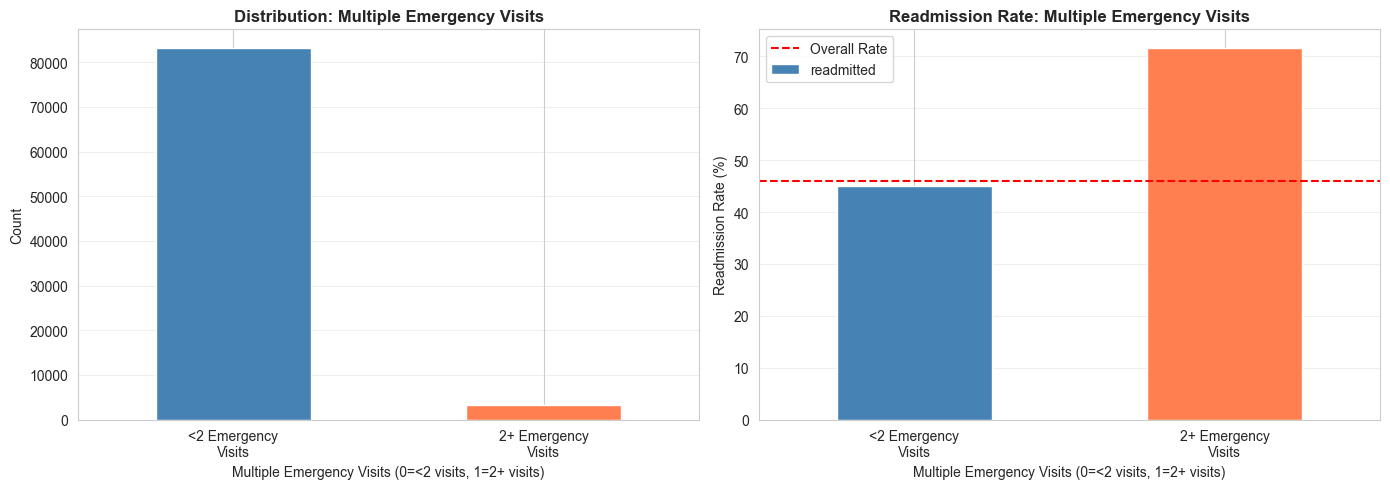

In [6]:
# Feature 1: Multiple Emergency Visits
# Binary indicator for patients with 2+ emergency visits in past year

# Create binary indicator: 1 if patient has 2+ emergency visits, 0 otherwise
df_clean['multiple_emergency_visits'] = (df_clean['number_emergency'] >= 2).astype(int)

print(f"Patients with 2+ emergency visits: {df_clean['multiple_emergency_visits'].sum():,} ({df_clean['multiple_emergency_visits'].mean()*100:.1f}%)")
print(f"Patients with <2 emergency visits: {(df_clean['multiple_emergency_visits'] == 0).sum():,} ({(df_clean['multiple_emergency_visits'] == 0).sum()/len(df_clean)*100:.1f}%)")

# Calculate readmission rates
print("\nReadmission Rates by Multiple Emergency Visits:")
emergency_readmit = df_clean.groupby('multiple_emergency_visits')['readmitted'].apply(
    lambda x: (x != 'NO').sum() / len(x) * 100
)
print(emergency_readmit)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
emergency_counts = df_clean['multiple_emergency_visits'].value_counts().sort_index()
emergency_counts.plot(kind='bar', ax=axes[0], color=['steelblue', 'coral'])
axes[0].set_title('Distribution: Multiple Emergency Visits', fontweight='bold')
axes[0].set_xlabel('Multiple Emergency Visits (0=<2 visits, 1=2+ visits)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['<2 Emergency\nVisits', '2+ Emergency\nVisits'], rotation=0)
axes[0].grid(axis='y', alpha=0.3)

# Readmission rate comparison
emergency_readmit.plot(kind='bar', ax=axes[1], color=['steelblue', 'coral'])
axes[1].set_title('Readmission Rate: Multiple Emergency Visits', fontweight='bold')
axes[1].set_xlabel('Multiple Emergency Visits (0=<2 visits, 1=2+ visits)')
axes[1].set_ylabel('Readmission Rate (%)')
axes[1].set_xticklabels(['<2 Emergency\nVisits', '2+ Emergency\nVisits'], rotation=0)
axes[1].axhline(y=df_clean['readmitted'].apply(lambda x: 1 if x != 'NO' else 0).mean()*100, 
                color='r', linestyle='--', label='Overall Rate')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


### Feature 2: High Comorbidity Count

**Rationale**:
- EDA showed readmitted patients had more diagnoses (7.7 vs 7.2)
- Multiple diagnoses (comorbidities) indicate complex medical conditions that are harder to manage
- Patients with above-average diagnosis counts are at higher risk because:
  - More conditions to monitor and treat
  - Higher likelihood of complications or interactions between conditions
  - More complex care management needs
- This is interpretable: "Patient has above-median number of diagnoses" directly explains complexity burden

**Calculation**:
Binary indicator: 1 if patient has above-median number of diagnoses, 0 otherwise


Median number of diagnoses: 8.0
Patients with high comorbidity count (> 8): 42,138 (48.8%)
Patients with low comorbidity count (≤ 8): 44,247 (51.2%)

Readmission Rates by Comorbidity Count:
high_comorbidity_count
0    41.801704
1    50.488870
Name: readmitted, dtype: float64

Mean Number of Diagnoses by Group:
high_comorbidity_count
0    5.916514
1    9.010845
Name: number_diagnoses, dtype: float64


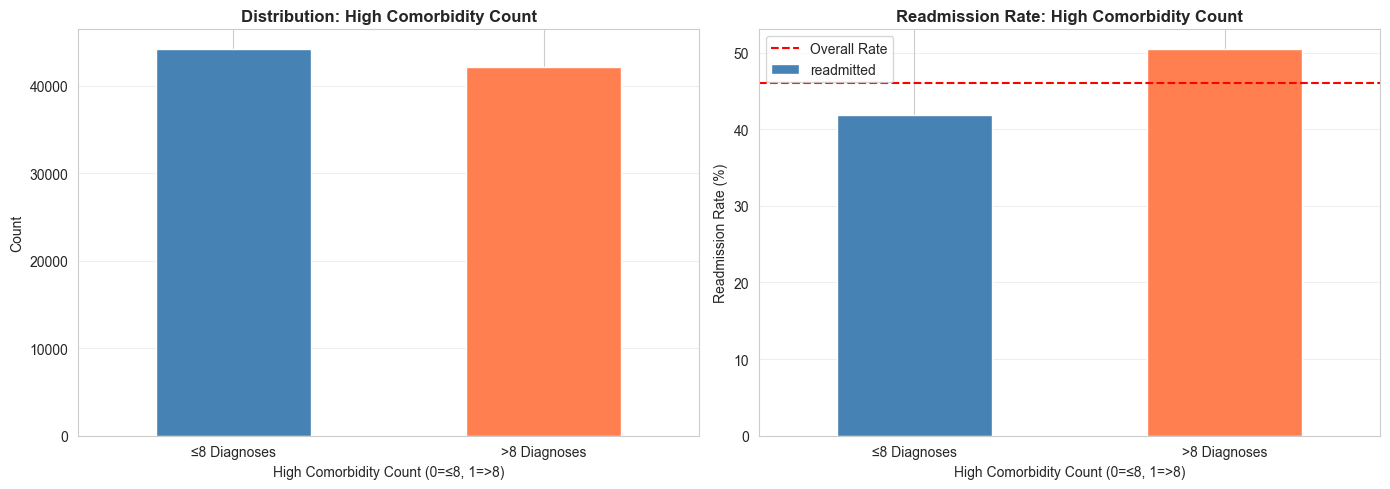

In [7]:
# Feature 2: High Comorbidity Count
# Binary indicator for patients with above-median number of diagnoses

# Calculate median number of diagnoses
median_diagnoses = df_clean['number_diagnoses'].median()

# Create binary indicator: 1 if above median, 0 otherwise
df_clean['high_comorbidity_count'] = (df_clean['number_diagnoses'] > median_diagnoses).astype(int)

print(f"Median number of diagnoses: {median_diagnoses:.1f}")
print(f"Patients with high comorbidity count (> {median_diagnoses:.0f}): {df_clean['high_comorbidity_count'].sum():,} ({df_clean['high_comorbidity_count'].mean()*100:.1f}%)")
print(f"Patients with low comorbidity count (≤ {median_diagnoses:.0f}): {(df_clean['high_comorbidity_count'] == 0).sum():,} ({(df_clean['high_comorbidity_count'] == 0).sum()/len(df_clean)*100:.1f}%)")

# Calculate readmission rates
print()
print("Readmission Rates by Comorbidity Count:")
comorbidity_readmit = df_clean.groupby('high_comorbidity_count')['readmitted'].apply(
    lambda x: (x != 'NO').sum() / len(x) * 100
)
print(comorbidity_readmit)

# Show mean diagnoses by group
print()
print("Mean Number of Diagnoses by Group:")
print(df_clean.groupby('high_comorbidity_count')['number_diagnoses'].mean())

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
comorbidity_counts = df_clean['high_comorbidity_count'].value_counts().sort_index()
comorbidity_counts.plot(kind='bar', ax=axes[0], color=['steelblue', 'coral'])
axes[0].set_title('Distribution: High Comorbidity Count', fontweight='bold')
axes[0].set_xlabel(f'High Comorbidity Count (0=≤{median_diagnoses:.0f}, 1=>{median_diagnoses:.0f})')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels([f'≤{median_diagnoses:.0f} Diagnoses', f'>{median_diagnoses:.0f} Diagnoses'], rotation=0)
axes[0].grid(axis='y', alpha=0.3)

# Readmission rate comparison
comorbidity_readmit.plot(kind='bar', ax=axes[1], color=['steelblue', 'coral'])
axes[1].set_title('Readmission Rate: High Comorbidity Count', fontweight='bold')
axes[1].set_xlabel(f'High Comorbidity Count (0=≤{median_diagnoses:.0f}, 1=>{median_diagnoses:.0f})')
axes[1].set_ylabel('Readmission Rate (%)')
axes[1].set_xticklabels([f'≤{median_diagnoses:.0f} Diagnoses', f'>{median_diagnoses:.0f} Diagnoses'], rotation=0)
axes[1].axhline(y=df_clean['readmitted'].apply(lambda x: 1 if x != 'NO' else 0).mean()*100, 
                color='r', linestyle='--', label='Overall Rate')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


### Feature 3: Medication Change Count

**Rationale**:
- Medication dosage changes (increases or decreases) indicate treatment instability or ongoing medication titration
- Patients with multiple medication changes may be at higher readmission risk because:
  - Frequent dosage adjustments suggest symptoms aren't well-controlled
  - Multiple changes indicate complex medication management
  - Treatment instability may reflect unstable clinical condition
- This is interpretable: "Patient had X medications with dosage adjustments" directly explains treatment complexity
- This aggregates information across 23 individual medication columns into one meaningful feature

**Calculation**:
Count of medications where dosage was changed (either "up" or "down" during the encounter)


Number of medication columns analyzed: 23
Mean medication changes per patient: 0.29
Median medication changes per patient: 0.00
Max medication changes: 4

Distribution:
medication_change_count
0    62784
1    22388
2     1115
3       94
4        4
Name: count, dtype: int64

Readmission Rates by Medication Change Count:
med_change_bin
0 changes      44.078109
1 change       51.375737
2 changes      49.237668
3-5 changes    46.938776
6+ changes           NaN
Name: readmitted, dtype: float64


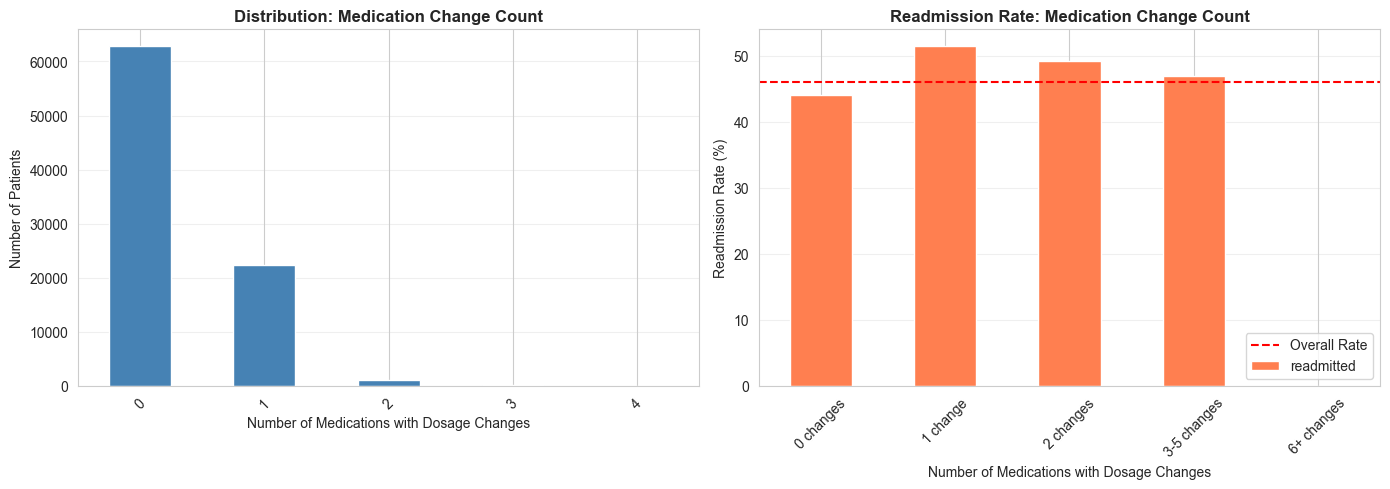

In [8]:
# Feature 3: Medication Change Count
# Count of medications with dosage changes (up or down)

# List of all medication columns
medication_cols = [
    'sertraline', 'escitalopram', 'fluoxetine', 'paroxetine', 'venlafaxine', 
    'duloxetine', 'buspirone', 'clonazepam', 'alprazolam', 'lorazepam', 
    'diazepam', 'hydroxyzine', 'propranolol', 'pregabalin', 'gabapentin', 
    'trazodone', 'mirtazapine', 'psychotherapy',
    'sertraline-buspirone', 'escitalopram-clonazepam', 'venlafaxine-lorazepam', 
    'sertraline-diazepam', 'sertraline-lorazepam'
]

# Find medication columns that exist in the dataset
available_med_cols = [col for col in medication_cols if col in df_clean.columns]


# Count medications with dosage changes (up or down)
# For each row, count how many medications have "up" or "down" values
def count_med_changes(row):
    count = 0
    for col in available_med_cols:
        if pd.notna(row[col]) and str(row[col]).upper() in ['UP', 'DOWN']:
            count += 1
    return count

df_clean['medication_change_count'] = df_clean.apply(count_med_changes, axis=1)

print(f"Number of medication columns analyzed: {len(available_med_cols)}")
print(f"Mean medication changes per patient: {df_clean['medication_change_count'].mean():.2f}")
print(f"Median medication changes per patient: {df_clean['medication_change_count'].median():.2f}")
print(f"Max medication changes: {df_clean['medication_change_count'].max()}")
print()
print(f"Distribution:")
print(df_clean['medication_change_count'].value_counts().sort_index().head(10))

# Calculate readmission rates by medication change count
print("\nReadmission Rates by Medication Change Count:")
# Group into bins for easier interpretation
df_clean['med_change_bin'] = pd.cut(df_clean['medication_change_count'], 
                                        bins=[-1, 0, 1, 2, 5, 100], 
                                        labels=['0 changes', '1 change', '2 changes', '3-5 changes', '6+ changes'])
med_change_readmit = df_clean.groupby('med_change_bin')['readmitted'].apply(
    lambda x: (x != 'NO').sum() / len(x) * 100
)
print(med_change_readmit)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of medication change counts (capped at 5 for readability)
med_change_dist = df_clean['medication_change_count'].value_counts().sort_index()
med_change_dist_capped = med_change_dist[med_change_dist.index <= 5]
med_change_dist_capped.plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Distribution: Medication Change Count', fontweight='bold')
axes[0].set_xlabel('Number of Medications with Dosage Changes')
axes[0].set_ylabel('Number of Patients')
axes[0].grid(axis='y', alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Readmission rate by medication change bins
med_change_readmit.plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Readmission Rate: Medication Change Count', fontweight='bold')
axes[1].set_xlabel('Number of Medications with Dosage Changes')
axes[1].set_ylabel('Readmission Rate (%)')
axes[1].axhline(y=df_clean['readmitted'].apply(lambda x: 1 if x != 'NO' else 0).mean()*100, 
                color='r', linestyle='--', label='Overall Rate')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Clean up temporary bin column
df_clean = df_clean.drop(columns=['med_change_bin'])


## Summary and Validation


In [9]:
# Summary of new features

print(f"1. Multiple Emergency Visits (multiple_emergency_visits)")
print(f"   - Purpose: Flags patients with 2+ emergency visits in past year")
print(f"   - Type: Binary (0/1)")
print(f"   - Why it helps: Indicates recurrent health instability - patients with multiple ER visits")
print(f"     have ongoing acute health issues that aren't being managed well")
print(f"   - Interpretable: Directly explains WHY patient is high-risk (recurrent emergency care)")

print()
print(f"2. High Comorbidity Count (high_comorbidity_count)")
print(f"   - Purpose: Flags patients with above-median number of diagnoses (comorbidities)")
print(f"   - Type: Binary (0/1)")
print(f"   - Why it helps: Multiple conditions are harder to manage, increase risk of complications,")
print(f"     and indicate more complex care needs")
print(f"   - Interpretable: Directly explains WHY patient is high-risk (multiple medical conditions)")

print()
print(f"3. Medication Change Count (medication_change_count)")
print(f"   - Purpose: Counts number of medications with dosage changes (up/down) during encounter")
print(f"   - Type: Integer (count)")
print(f"   - Why it helps: Multiple medication changes indicate treatment instability or ongoing titration,")
print(f"     suggesting symptoms aren't well-controlled or condition is unstable")
print(f"   - Interpretable: Directly explains WHY patient is high-risk (treatment instability)")

print()
print(f"Final Dataset Info:")
print(f"  - Shape: {df_clean.shape}")
print(f"  - Columns: {len(df_clean.columns)}")
print(f"  - New features added: 3")
print(f"  - Columns dropped: {len(columns_to_drop)}")

# Check for any issues
print()
print(f"Data Quality Checks:")
new_features = ['multiple_emergency_visits', 'high_comorbidity_count', 'medication_change_count']
print(f"  - Missing values in new features: {df_clean[new_features].isnull().sum().sum()}")
print(f"  - Duplicate rows: {df_clean.duplicated().sum()}")

# Show correlation of new features with readmission
print()
print(f"Feature Correlation with Readmission (binary):")
df_clean['readmitted_binary'] = (df_clean['readmitted'] != 'NO').astype(int)
correlations = df_clean[new_features + ['readmitted_binary']].corr()
print(correlations['readmitted_binary'].sort_values(ascending=False))


1. Multiple Emergency Visits (multiple_emergency_visits)
   - Purpose: Flags patients with 2+ emergency visits in past year
   - Type: Binary (0/1)
   - Why it helps: Indicates recurrent health instability - patients with multiple ER visits
     have ongoing acute health issues that aren't being managed well
   - Interpretable: Directly explains WHY patient is high-risk (recurrent emergency care)

2. High Comorbidity Count (high_comorbidity_count)
   - Purpose: Flags patients with above-median number of diagnoses (comorbidities)
   - Type: Binary (0/1)
   - Why it helps: Multiple conditions are harder to manage, increase risk of complications,
     and indicate more complex care needs
   - Interpretable: Directly explains WHY patient is high-risk (multiple medical conditions)

3. Medication Change Count (medication_change_count)
   - Purpose: Counts number of medications with dosage changes (up/down) during encounter
   - Type: Integer (count)
   - Why it helps: Multiple medication cha

In [10]:
# Save cleaned dataset
output_path = 'Data/anxiety_disorder_admission_data_cleaned.csv'
df_clean.to_csv(output_path, index=False)
print(f"Cleaned dataset saved to: {output_path}")


Cleaned dataset saved to: Data/anxiety_disorder_admission_data_cleaned.csv
